In [4]:
# https://qiskit.org/documentation/tutorials/circuits/1_getting_started_with_qiskit.html
# https://qiskit.org/documentation/machine-learning/tutorials/03_quantum_kernel.html
# https://github.com/marcinjastrzebski8/QuantumKernelEstimation  (useful as a small guide)

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, BasicAer, transpile
from qiskit import BasicAer
from qiskit.circuit import ParameterVector
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from cvxopt import matrix, solvers
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

seed = 12345
algorithm_globals.random_seed = seed

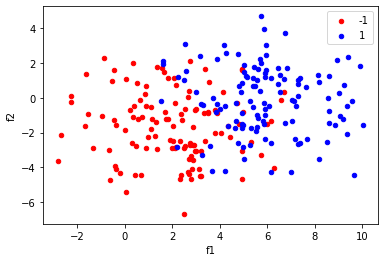

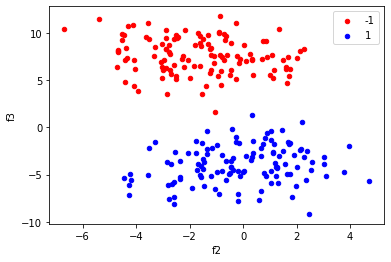

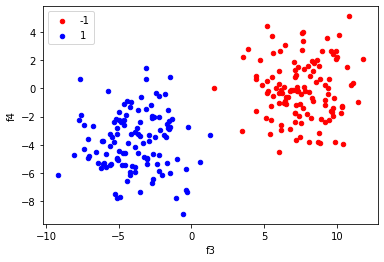

In [5]:
# Creating a dataset
# The smaller the cluster_std, the more appart and easier to distinguish they are
num_samples_train = 200
num_samples_test = 40
num_features = 4

num_samples = num_samples_train + num_samples_test
all_features, all_labels_init = make_blobs(n_samples=num_samples, centers=2, cluster_std=2, n_features=num_features)

features_train = all_features[:num_samples_train]
features_test = all_features[num_samples_train:]

labels = all_labels_init
labels = np.where(all_labels_init == 0, -1, all_labels_init)

labels_train = labels[:num_samples_train]
labels_test = labels[num_samples_train:]

# Displaying the dataset
features_dict = {}
for i in range(len(all_features[0])):
    col_name = "f" + str(i+1)
    features_dict [col_name] = all_features[:,i]
    
features_dict["label"] = labels
df = DataFrame(features_dict, labels)
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f1', y='f2', label=key, color=colors[key])
plt.show()

features_dict["label"] = labels
df = DataFrame(features_dict, labels)
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f2', y='f3', label=key, color=colors[key])
plt.show()

features_dict["label"] = labels
df = DataFrame(features_dict, labels)
colors = {-1:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('label')

for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='f3', y='f4', label=key, color=colors[key])
plt.show()

In [6]:
### Custom Feature Map

# for now, we have as many qubits as features
num_qubits = num_features

# iter is number of times to repeat the circuit
iter = 1              

# creating a list of parameters
x = ParameterVector('x', length=num_qubits)  
custom_circ = QuantumCircuit(num_qubits)

# defining the parametrised circuit to be used as a feature map
for _ in range(iter):
    for i in range(num_qubits):
        custom_circ.h(i)
    for i in range(num_qubits):
        custom_circ.rz(x[i], i)
    for i in range(1, num_qubits):
        custom_circ.cx(0, i)
        custom_circ.rz(x[i], i)
        custom_circ.cx(0, i)
custom_circ.draw()

# creating the feature map and extracting the kernel matrix
backend = QuantumInstance(BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed)
#fm = ZZFeatureMap(feature_dimension=4)
qk = QuantumKernel(feature_map=custom_circ, quantum_instance=backend)
K = qk.evaluate(features_train)

In [7]:
# Computing the alphas of the SVM algorithm
lambda_svm = 1
Q = np.zeros((num_samples_train, num_samples_train))
for i in range(num_samples_train):
    for j in range(num_samples_train):
        Q[i][j] = labels[i] * labels[j] * K[i][j]
Pm = np.eye(num_samples_train) / lambda_svm + Q

P = matrix(Pm, tc='d')
q = matrix(-np.ones(num_samples_train), tc='d')
G = matrix(-np.eye(num_samples_train), tc='d')
h = matrix(np.zeros(num_samples_train), tc='d')

sol = solvers.qp(P,q,G,h)

     pcost       dcost       gap    pres   dres
 0: -6.3620e+01 -1.7091e+02  1e+02  0e+00  2e+00
 1: -7.7487e+01 -8.4264e+01  7e+00  2e-15  3e-01
 2: -8.3012e+01 -8.3678e+01  7e-01  2e-15  1e-03
 3: -8.3012e+01 -8.3019e+01  7e-03  2e-15  1e-05
 4: -8.3012e+01 -8.3012e+01  7e-05  2e-15  1e-07
 5: -8.3012e+01 -8.3012e+01  7e-07  2e-15  1e-09
Optimal solution found.


In [8]:
alpha = (np.array(sol['x']).T)[0]
print(len(alpha))

200


In [9]:
good = 0
bad = 0
for test_idx in range(num_samples_test):
    new_sum = 0
    
    for train_idx in range(num_samples_train):
        pair = np.zeros((2, num_features))
        pair[0] = features_train[train_idx]
        pair[1] = features_test[test_idx]
        current_K = qk.evaluate(pair)
        #print(current_K)
        new_sum = new_sum + alpha[train_idx] * labels_train[train_idx] * current_K[0][1] # x_i vs x (test)
    
    if int(new_sum/abs(new_sum)) == int(labels_test[test_idx]):
        good = good + 1
    else:
        bad = bad + 1

print("Well classified: ", good)
print("Bad classified: ", bad)
print("Accuracy: ", round(good / (good + bad), 4))

Well classified:  18
Bad classified:  22
Accuracy:  0.45
